# Voyages API - Floating Storages

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/VoyagesAPI/VoyagesAPI-FloatingStorages.ipynb). 

<p style="text-align: justify"> 
     Floating Storages are laden vessels that remain stopped, instead of directly proceeding with the laden part of the voyage and the discharge of the cargo. This is usually performed for trading reasons. The minimum duaration for a stop to be classified as a Floating Storage is 7 days for concluded Stops and 3 days for ongoing ones. 
</p>

<p style="text-align: justify"> 
    Very often arises the need of conducting an analysis of the total quantity of the quantity of oil that remains in floating storages, either globally or in a specific area/port and for a given time window. This is accommodated by the <b>VoyagesData API</b>.
</p>

Both `get_voyages_by_advanced_search` and `get_voyages_flat_by_advanced_search` of the Signal SDK facilititate this need. In this example, we will be constructing a dataframe with all the floating storage events of interest, from which a time series of total stored quantitites will be derived.



## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key acquired here: https://apis.signalocean.com/profile

In [ ]:
pip install signal-ocean

In [ ]:
signal_ocean_api_key = '' #replace with your subscription key

In [2]:
from signal_ocean import Connection
from signal_ocean.voyages import VoyagesAPI
from signal_ocean.voyages import VesselClass, VesselClassFilter
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
connection = Connection(signal_ocean_api_key)
api = VoyagesAPI(connection)

### Get voyages

For this tutorial we will retrieve the voyages of VLCC vessels that have ended after January 2020, including those still ongoing. To add other vessel classes like Suezmaxes or Aframaxes, you can retrieve the corresponding VesselClassIDs and add them to the list

In [5]:
#get vessel class id for vlcc
vc = api.get_vessel_classes(VesselClassFilter('vlcc'))[0]
vlcc_id = vc.vessel_class_id

In [6]:
end_date_from = date(2019, 9, 1)

In [7]:
vc_list = [vlcc_id]

In [8]:
%%time
voyages_api = api.get_voyages_by_advanced_search(
    vessel_class_ids = [*vc_list],
    end_date_from = end_date_from
)

Wall time: 3min 24s


We will now extract the voyages in a data frame format.

In [9]:
voyages_df = pd.DataFrame(v.__dict__ for v in voyages_api)

Here we split the voyages into seagoing vessels and storage vessels. We can either include or exclude storage vessels by setting the approproate flag. There are some edge cases wherein the calculated cargo and quantity are null. We treat this case separately by assigning $80\%$ of their deadweight.

In [10]:
exclude_storage_vessels = False

# extracting floating storage events
floating_storage_events_data = []

for iVoyage, r in voyages_df.iterrows():
    imo = r['imo']
    voyage_number = r['voyage_number']
    vessel_class = r['vessel_class']
    cargo_group = r['cargo_group']
    cargo_type_id = r['cargo_type_id']
    cargo_type = r['cargo_type']
    quantity = r['quantity']
    if not quantity:
        quantity = r['deadweight'] * 0.8
        cargo_group = 'Dirty'
        cargo_type_id = 19
        cargo_type = 'Crude Oil'

    events = r['events']
    
    for event in events:
        if not event.event_details:
            continue
        if exclude_storage_vessels and e.purpose == 'StorageVessel':
            continue
        port_name = event.port_name
        country = event.country
        area_name_level0 = event.area_name_level0
        
        for event_detail in event.event_details:
            if not event_detail.floating_storage_start_date:
                continue
            floating_storage_start_date = event_detail.floating_storage_start_date
            floating_storage_duration = event_detail.floating_storage_duration
            
            floating_storage_events_data.append([
                imo, voyage_number, vessel_class,cargo_group,cargo_type,cargo_type_id,area_name_level0, quantity,
                port_name, country, floating_storage_start_date, 
                floating_storage_duration
            ])
            
floating_storage_events_df = pd.DataFrame(floating_storage_events_data, 
                                           columns=['imo', 'voyage_number', 'vessel_class','cargo_group', 'cargo_type',
                                                    'cargo_type_id','area_name_level0',
                                                    'quantity', 'port_name', 'country','floating_storage_start_date', 
                                                    'floating_storage_duration'
                                                   ])

Signal uses default thresholds in days after which an event is considered a floating storage event. However, we can also implement custom, stricter thresholds. Here the user can set a higher threshold for a Stop to be considered as a Floating Storage. In this example, we use 20 days. 

In [11]:
# define the threshold in days to filter floating_storage_duration
lower_threshold = 20  
floating_storage_events_df = floating_storage_events_df.query("floating_storage_duration >= @lower_threshold")

We extract only the date from the datetime object floating_storage_start_date, since the duration is given in days and, thus, the exact time is not relevant.

In [12]:
floating_storage_events_df.loc[:, 'floating_storage_start_date'] = floating_storage_events_df.floating_storage_start_date.apply(lambda x: x.date())

If you want to exclude a specific range of cargoes like fueloils, we add them in an "excluded" list. This is mostly revelant for classes smaller than VLCCs.

In [13]:
dirty_cargoes = list(floating_storage_events_df[(floating_storage_events_df.cargo_group == 'Dirty')].cargo_type.unique())

In [14]:
fueloils = [cargo for cargo in dirty_cargoes if 'fueloil' in cargo.lower().split()]
excluded = [*fueloils]

In [15]:
floating_storage_events_df = floating_storage_events_df[(floating_storage_events_df.cargo_group == 'Dirty') &
                                                        (~floating_storage_events_df.cargo_type.isin(excluded))
                                                       ].copy()

We create the new column floating_storage_end_date base on floating_storage_start_date and the duration.

In [16]:
floating_storage_events_df['floating_storage_end_date'] = floating_storage_events_df.apply(
    lambda r: r['floating_storage_start_date'] + relativedelta(days=r['floating_storage_duration']), axis=1)

Next, we transform the column names to CamelCase and select the desired columns from the dataframe.

In [17]:
def snake_to_camel(word):
    return ''.join(x.capitalize() or '_' for x in word.split('_'))

In [18]:
floating_storage_events_df.columns = [*map(snake_to_camel, floating_storage_events_df.columns)]
floating_storage_events_df = floating_storage_events_df[['Imo', 'VoyageNumber', 'VesselClass', 'CargoType', 'Quantity',
                                                         'AreaNameLevel0',
                                                         'PortName', 'Country', 'FloatingStorageStartDate',
                                                         'FloatingStorageEndDate'
                                                        ]].copy()
floating_storage_events_df.head(2)

,Imo,VoyageNumber,VesselClass,CargoType,Quantity,AreaNameLevel0,PortName,Country,FloatingStorageStartDate,FloatingStorageEndDate
8,9043029,1,VLCC,Crude Oil,241000.0,Indonesia,Gagak Rimang FSO,Indonesia,2014-12-31,2023-07-20
10,9078359,1,VLCC,Cameroon Crude Oil,215000.0,Arabian Gulf,Ras Laffan,Qatar,2020-03-20,2020-05-21


Here we set the date range under consideration for the plots. For the first plot, we focus on the Red Sea area, during 2023.

In [19]:
# min and max dates for consideration
date_min = date(2023, 1, 1)
date_max = date(2023, 7, 1)

delta = (date_max - date_min).days

In [20]:
red_sea_events_df = floating_storage_events_df[floating_storage_events_df.AreaNameLevel0 == 'Red Sea'].copy()

We convert the quantity from MT (QMT) to kilo barrels (QKB), using the formula $QKB = \frac{(QMT/1000) \times (APIGravity + 131.5)}{141.5\times 0.159}$. For now we use the API Gravity of Crude Oil, which is 28, but the Cargo API has the exact value.

In [21]:
floating_oil_daily_data = []

for iDay in range(delta):
    curr_date = date_min + relativedelta(days=iDay)
    events_on_curr_date = red_sea_events_df[(red_sea_events_df.FloatingStorageStartDate <= curr_date) &
                                                   (red_sea_events_df.FloatingStorageEndDate >= curr_date)
                                                  ].copy()
    if events_on_curr_date.empty:
        quantity_on_water = 0
    else:
        quantity_on_water =  events_on_curr_date.apply(lambda r: 
                                    r['Quantity'] * (28 + 131.5) / (141.5 * 0.159) / 1_000_000, axis=1).sum()
    floating_oil_daily_data.append([curr_date, quantity_on_water])


In [22]:
floating_oil_series = pd.DataFrame(floating_oil_daily_data, columns=['Date', 'Quantity'])

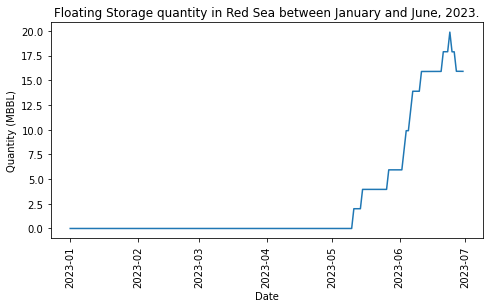

In [23]:
fig1 = plt.figure(figsize=(6, 3))
axes1 = fig1.add_axes([0, 0, 1, 1])
axes1.plot(floating_oil_series.Date, floating_oil_series.Quantity)

axes1.set_title('Floating Storage quantity in Red Sea between January and June, 2023.')
axes1.set_xlabel('Date')
axes1.set_ylabel('Quantity (ΜBBL)')
plt.xticks(rotation = 90)
plt.show()

For the second plot, we will show the global monthly trend during 2020, the year the global COVID-19 pandemic broke out.

In [24]:
# min and max dates for consideration
date_min = date(2020, 1, 1)
date_max = date(2021, 7, 1)

delta = (date_max - date_min).days

In [25]:
floating_oil_daily_data = []

for iDay in range(delta):
    curr_date = date_min + relativedelta(days=iDay)
    events_on_curr_date = floating_storage_events_df[(floating_storage_events_df.FloatingStorageStartDate <= curr_date) &
                                                   (floating_storage_events_df.FloatingStorageEndDate >= curr_date)
                                                  ].copy()
    if events_on_curr_date.empty:
        quantity_on_water = 0
    else:
        quantity_on_water =  events_on_curr_date.apply(lambda r: 
                                    r['Quantity'] * (28 + 131.5) / (141.5 * 0.159) / 1_000_000, axis=1).sum()
    floating_oil_daily_data.append([curr_date, quantity_on_water])


In [26]:
floating_oil_series = pd.DataFrame(floating_oil_daily_data, columns=['Date', 'Quantity'])
floating_oil_series['Date'] = pd.to_datetime(floating_oil_series['Date'])

We take the average quantity of each month to be the month quantity

In [27]:
floating_oil_monthly_series = floating_oil_series.resample('M', on='Date').mean().reset_index()
floating_oil_monthly_series.head(2)

,Date,Quantity
0,2020-01-31,63.642799
1,2020-02-29,62.781919


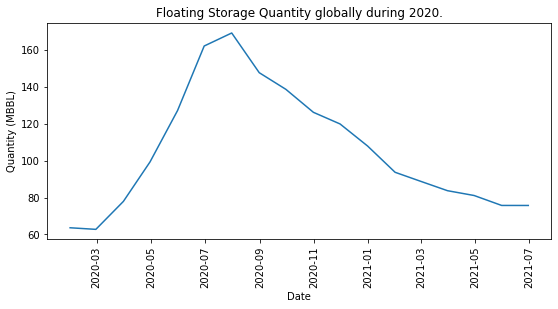

In [28]:
fig2 = plt.figure(figsize=(7, 3))
axes2 = fig2.add_axes([0, 0, 1, 1])
axes2.plot(floating_oil_monthly_series.Date, floating_oil_monthly_series.Quantity)

axes2.set_title('Floating Storage Quantity globally during 2020.')
axes2.set_xlabel('Date')
axes2.set_ylabel('Quantity (ΜBBL)')
plt.xticks(rotation = 90)
plt.show()